In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats

# Data loading
Я обрав компанію Goldman Sachs.

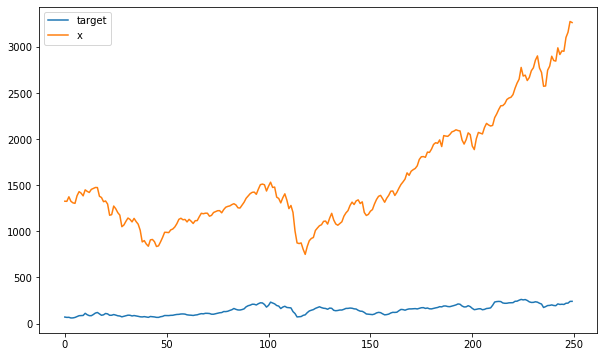

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data_gs = pd.read_csv('GS.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_sp500 = pd.read_csv('^GSPC.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

target = ((data_gs['High'] + data_gs['Low']) / 2.).values
x = ((data_sp500['High'] + data_sp500['Low'])/2.).values

plt.figure(figsize=(10, 6))
plt.plot(target, label='target')
plt.plot(x, label='x')
plt.legend();

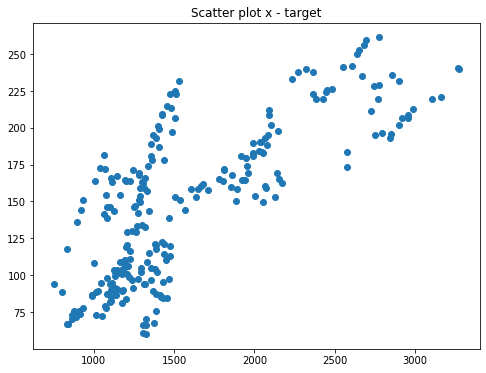

In [3]:
plt.figure(figsize=(8, 6))
plt.title('Scatter plot x - target')
plt.scatter(x, target);

### Model parameters

In [4]:
def model_parameters_1(x, y):
    n = x.shape[0]
    x_mean = x.mean()
    y_mean = target.mean()
    x_y_product = np.dot(x, target)
    beta = ((x_y_product / n) - x_mean * y_mean ) / (1 / n * np.sum(x ** 2) - x_mean **2 )
    alpha = y_mean - beta * x_mean
    
    print(f'=== Model1 coef ===')
    print(f'alpha: {alpha}    beta: {beta}')
    return alpha, beta

def model_parameters_2(x, y):
    x_mean = x.mean()
    y_mean = target.mean()
    beta = np.cov(x, target)[0][1] / np.var(x)
    alpha = y_mean - beta * x_mean
    
    print(f'=== Model2 coef ===')
    print(f'alpha: {alpha}    beta: {beta}')
    return alpha, beta

def model_parameters_3(x, y):
    from sklearn.linear_model import LinearRegression
    lin = LinearRegression()
    lin.fit(x.reshape(-1, 1), y)
    
    print(f'=== Model3 coef ===')
    print(f'alpha: {lin.intercept_}    beta: {lin.coef_[0]}')
    return lin.intercept_, lin.coef_[0]

def model_parameters_4(x, y):
    import statsmodels.api as sm
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    lin = model.fit()
    
    print(f'=== Model4 coef ===')
    print('alpha: {}    beta: {}'.format(lin.params[0], lin.params[1]))
    return lin.params[0], lin.params[1], lin


def predict(b_0, b_1, x):
    res = b_0 + b_1 * x
    return res

In [5]:
model_1 = model_parameters_1(x, target)
model_2 = model_parameters_2(x, target)
model_3 = model_parameters_3(x, target)
model_4 = model_parameters_4(x, target)

=== Model1 coef ===
alpha: 38.97806143775581    beta: 0.06838524253163744
=== Model2 coef ===
alpha: 38.545538653208496    beta: 0.06865988205987704
=== Model3 coef ===
alpha: 38.978061437755585    beta: 0.06838524253163758
=== Model4 coef ===
alpha: 38.97806143775567    beta: 0.06838524253163755


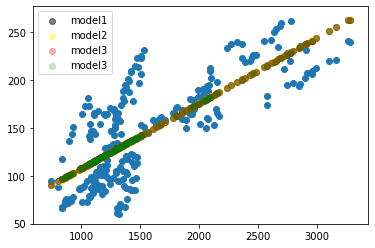

In [6]:
plt.scatter(x, target)
plt.scatter(x, predict(model_1[0], model_1[1], x), color='black', label='model1', alpha=0.5)
plt.scatter(x, predict(model_2[0], model_2[1], x), color='yellow', label='model2', alpha=0.4)
plt.scatter(x, predict(model_3[0], model_3[1], x), color='red', label='model3', alpha=0.3)
plt.scatter(x, predict(model_4[0], model_4[1], x), color='green', label='model3', alpha=0.2)
plt.legend();

# Model analysis

In [7]:
y_hat = predict(model_4[0], model_4[1], x)

In [8]:
model_4[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     360.1
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           3.29e-50
Time:                        11:52:59   Log-Likelihood:                -1233.3
No. Observations:                 250   AIC:                             2471.
Df Residuals:                     248   BIC:                             2478.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.9781      6.063      6.429      0.000      27.036      50.920
x1             0.0684      0.004     18.976      0.000       0.061       0.075
==============================================================================
Omnibus:                       11.987   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.680
Skew:                           0.482   Prob(JB):                      0.00291
Kurtosis:                       2.560   Cond. No.                     4.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Hypothesis testing  $\alpha$ = 0 
$H_0: \alpha = 0 $ <br>
$H_1: \alpha \ne 0 $ <br>
From the second table above in the __const__ row we can see that obtained t-test results are equal to 6.429 and corresponding p-value is 0.000. As obtained p-value is below 0.05 it means that the variable is significant . Therefore, the $\alpha$ is most probably different from 0. Lets check whether given confidence intervals in the table are true.

In [9]:
upper_bound = model_4[2].params[0] + stats.t.ppf(1-0.025, 250) * model_4[2].bse[0]
lower_bound = model_4[2].params[0] - stats.t.ppf(1-0.025, 250) * model_4[2].bse[0]
print('b_0 Upper_bound: ',upper_bound, ' Lower bound: ', lower_bound)

b_0 Upper_bound:  50.919581202263956  Lower bound:  27.03654167324738


### Hypothesis testing  $\beta$ = 0 
$H_0: \beta = 0 $ <br>
$H_1: \beta \ne 0 $ <br>
From the second table above in the __0__ row we can see that obtained t-test results are equal to 18.976 and corresponding p-value is 0.000. As obtained p-value is below 0.05 it means that the variable is significant . Therefore, the $\beta$ is most probably different from 0. Lets check whether given confidence intervals in the table are true.

In [10]:
upper_bound = model_4[2].params[1] + stats.t.ppf(1-0.025, 250) * model_4[2].bse[1]
lower_bound = model_4[2].params[1] - stats.t.ppf(1-0.025, 250) * model_4[2].bse[1]
print('b_1 Upper_bound: ',upper_bound, ' Lower bound: ', lower_bound)

b_1 Upper_bound:  0.07548289428884318  Lower bound:  0.061287590774431924


### r & $R^{2}$

In [11]:
# r and R_squared
print(f'table values R_squared: {model_4[2].rsquared}    r: {np.sqrt(model_4[2].rsquared)}') # program 
print(f'my values    R_squared: {np.var(y_hat) / np.var(target)}    r: {np.corrcoef(y_hat, target)[0][1]}') # my

table values R_squared: 0.5921631920270737    r: 0.769521404528213
my values    R_squared: 0.5921631920270741    r: 0.7695214045282126


### F-statistic
$H_0: \beta_1 ... \beta_n = 0 $  (if all $\beta$s are 0, then none of the independent variables matter. Therefore, our model has no merit)<br> 
$H_1$: at least one $\beta$ from $\beta_1 ... \beta_n \ne 0 $ <br>

In out case F-statistic is 360.01 with a p-value of close to 0.000. We can say that overall model is significant. One thing worth mentioning is, the lower the F-statistic, the closer model to be non-significant. 

### Predictions with 95% confidence intervals

In [12]:
yprd_ci_lower, yprd_ci_upper = summary_table(model_4[2], alpha = 0.05)[1][:, 4:6].T

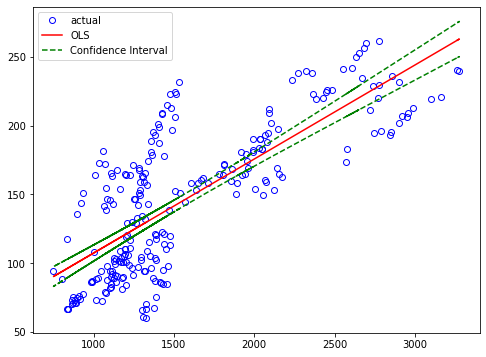

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(x, target, linestyle = "None", marker = "o", label = "actual", markerfacecolor = "None", color = "blue")
plt.plot(x, y_hat, color = "red", label = "OLS")
plt.plot(x, yprd_ci_lower, color = "green", linestyle = "--", label = "Confidence Interval")
plt.plot(x, yprd_ci_upper, color = "green", linestyle = "--")
plt.legend()
plt.show();

### Forecast

In [14]:
x_mat = x[-1] * 1.2
y_prd = predict(model_4[0], model_4[1], x_mat)
print(f'x = {x_mat} y_hat = {y_prd}')
print(f'y confidence intervals: ({y_prd}, {y_prd})')


x = 3917.2259766 y_hat = 306.85850989877747
y confidence intervals: (306.85850989877747, 306.85850989877747)
